# Test DoWhy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [4]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  1.638426 -0.898812  0.0  0.241225 -0.557451 -0.469597  0  1   8.481164   
1  0.982979 -0.833675  0.0  0.753986  1.076393  0.290562  3  1  27.243313   
2 -0.766244  0.510764  0.0  0.476494  1.048836  0.324237  1  3  25.731574   
3  1.910750 -0.479345  0.0  0.197486 -0.828333 -0.820219  0  0  -2.285596   
4  0.347246 -0.964891  0.0  0.143076 -0.468342 -0.029271  3  3  22.552089   

            y  
0   79.297986  
1  251.341950  
2  279.079957  
3  -30.675205  
4  165.080764  
True causal estimate is 10.58131847748639


In [5]:
model = CausalModel(data=data["df"],
                    treatment=data["treatment_name"], outcome=data["outcome_name"],
                    graph=data["gml_graph"])

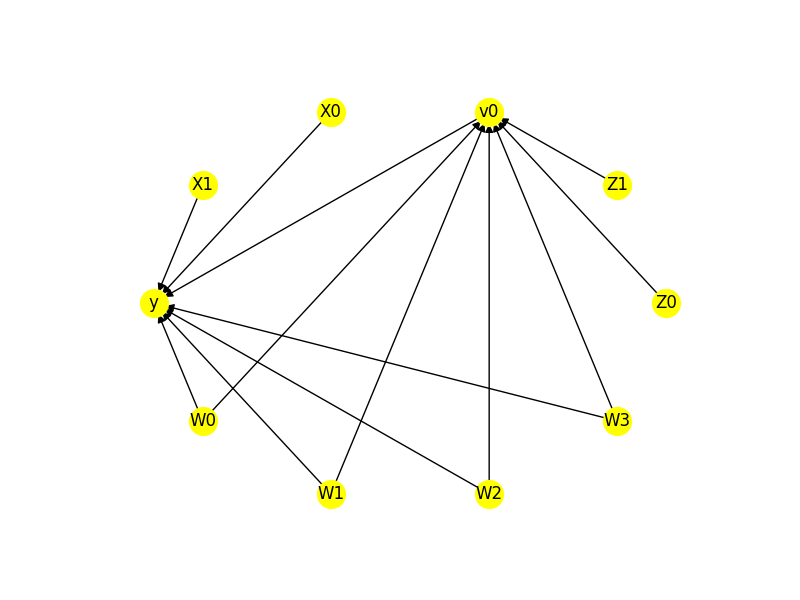

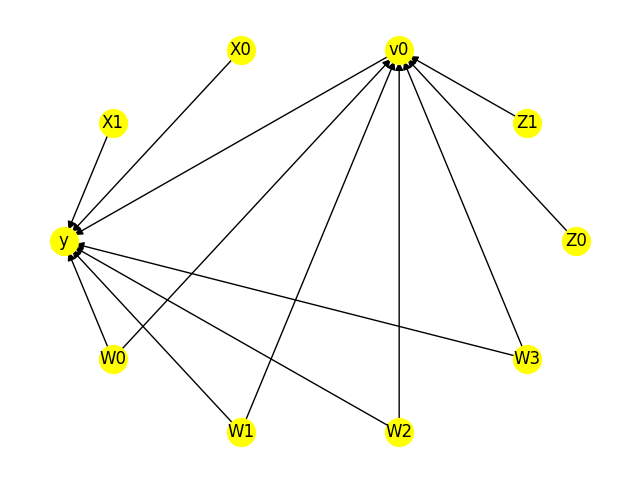

In [6]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1)
print(linear_estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 10.581105790570696
### Conditional Estimates
__categorical__X1  __categorical__X0
(-3.698, -1.048]   (-3.097, -0.101]      2.530746
                   (-0.101, 0.485]       4.068524
                   (0.485, 0.971]        5.166399
                   (0.971, 1.545]        6.150233
                   (1.545, 4.672]        7.681075
(-1.048, -0.458]   (-3.097, -0.101] 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                    control_value = 0,
                                    treatment_value = 1,
                                    target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                    confidence_intervals=False,
                                    method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                                'model_t': GradientBoostingRegressor(),
                                                                "model_final":LassoCV(fit_intercept=False),
                                                                'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                                "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 12.49538570335467
Effect estimates: [ 9.59640387 11.77455889 26.97615168 ... 20.56242717 14.16602054
 16.92154067]



In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from lightgbm import LGBMRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                    control_value = 0,
                                    treatment_value = 1,
                                    target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                    confidence_intervals=False,
                                    method_params={"init_params":{'model_y':LGBMRegressor(verbose=-1),
                                                                'model_t': LGBMRegressor(verbose=-1),
                                                                "model_final":LGBMRegressor(verbose=-1),
                                                                'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                                "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 16.468946142943995
Effect estimates: [12.25983541 14.9456613  35.40346626 ... 30.40380931 17.93135176
 20.79490692]



In [20]:
print("True causal estimate is", data["ate"])

True causal estimate is 10.58131847748639


In [25]:

dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                    control_value = 0,
                                    treatment_value = 1,
                                    target_units = 1,  # condition used for CATE
                                    confidence_intervals=False,
                                    method_params={"init_params":{'model_y':LGBMRegressor(verbose=-1),
                                                                'model_t': LGBMRegressor(verbose=-1),
                                                                "model_final":LGBMRegressor(verbose=-1),
                                                                'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                                "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: 

## Estimate
Mean value: 11.510842785480259
Effect estimates: [12.45255029  9.97288285  6.26149376 ...  7.76808041 13.45465587
 25.26780967]



In [26]:
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    target_units = "ate",
                                    confidence_intervals=True,
                                    method_params={"init_params":{'model_y':LGBMRegressor(verbose=-1),
                                                                'model_t': LGBMRegressor(verbose=-1),
                                                                "model_final": LGBMRegressor(verbose=-1),
                                                                'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                                "fit_params":{
                                                                'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                                })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 9.487440100353208
Effect estimates: [ 9.28494876  6.22173673  4.99071385 ...  6.52137841 10.80276538
 17.20434324]
95.0% confidence interval: (array([ 3.47810115, -2.04945458, -3.98641778, ...,  1.93002224,
       -0.15677289, 11.57949559]), array([13.60862642,  8.26138218,  7.43465273, ..., 11.05398355,
       13.08734599, 24.95801842]))



In [32]:
dml_estimate.get_confidence_intervals()[0].mean(), dml_estimate.get_confidence_intervals()[1].mean()

# Binary treatment and outcome

In [33]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=1, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"],
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"],
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        W0        W1        W2        W3  v0  y
0     0.404602 -0.424859  0.0 -2.186613  0.301517  0.422752 -2.192115   0  0
1     2.071723 -0.609771  0.0 -2.960443  2.026178 -0.317377 -0.856112   0  0
2    -0.326725  1.629798  0.0  1.098042 -0.736968  0.319728  0.209484   1  1
3     2.717549 -0.321095  0.0 -2.050475  1.266098 -0.340508 -0.366850   0  0
4    -0.029296  1.982493  0.0  0.810767  0.217142 -0.202851  1.440317   1  1
...        ...       ...  ...       ...       ...       ...       ...  .. ..
9995  1.203150  1.893204  0.0  1.515335 -1.659978 -0.447716 -0.247227   0  1
9996 -1.530981  1.787143  0.0 -0.241734  0.921942  1.194856 -1.529667   0  0
9997  1.757908  1.519548  0.0 -2.125695  0.697516  0.826558 -1.941370   0  0
9998  0.781785  0.081355  0.0 -0.277461  0.536293 -1.034047  1.234520   1  1
9999  1.220340  0.539319  0.0 -1.784937  1.473066 -1.157833 -2.052624   0  0

[10000 rows x 9 columns]


In [34]:
from sklearn.linear_model import LogisticRegressionCV
# todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary,
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                                "fit_params":{}
                                                })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.7163357663751744
Effect estimates: [0.61376224 0.64965059 0.73521558 ... 0.78850152 0.65998132 0.70464048]

True causal estimate is 0.6795


In [45]:
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary,
                                method_name="backdoor.econml.dr.LinearDRLearner",
                                confidence_intervals=True,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                                "fit_params":{
                                                                'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                                })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W3,W0,W2])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W2,U) = P(y|v0,W1,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: ate

## Estimate
Mean value: 0.7205036390738861
Effect estimates: [0.61993471 0.65563153 0.73859169 ... 0.79146156 0.66531057 0.70917996]
95.0% confidence interval: (array([0.5640067 , 0.56462981, 0.6530552 , ..., 0.47381372, 0.6218893 ,
       0.65013045]), array([0.96370483, 0.8106315 , 1.01442176, ..., 0.8238539 , 0.86797364,
       0.77405133]))

True causal estimate is 0.6795


In [46]:
drlearner_estimate.get_confidence_intervals()[0].mean(), drlearner_estimate.get_confidence_intervals()[1].mean()

In [44]:
drlearner_estimate.get_confidence_intervals()

In [35]:
dmliv_estimate = model.estimate_effect(identified_estimand,
                                        method_name="iv.econml.iv.dml.DMLIV",
                                        target_units = lambda df: df["X0"]>-1,
                                        confidence_intervals=False,
                                method_params={"init_params":{
                                                                'discrete_treatment':False,
                                                                'discrete_instrument':False
                                                                },
                                                "fit_params":{}})
print(dmliv_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W1+W3+W0+W2 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 10.72286534789395
Effect estimates: [ 9.68405569  8.68644847 10.41979659 ...  5.58802914 14.05458996
 16.70819548]



In [36]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"],
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"],
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -1.691228 -2.165564  2.581948  0.220092  0.025889  0.0  0.792584   
1    -1.004057  1.817000  2.302724  0.336175 -2.910574  0.0  0.028866   
2     0.589417 -0.645648  0.314175 -1.048761  0.342202  0.0  0.966637   
3    -0.594741 -0.798485  2.490752  0.101732  0.276267  0.0  0.648563   
4     2.747751  0.777424  0.584673 -0.729902  1.920522  0.0  0.201970   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.250668 -0.466331  1.702516 -0.507131  0.733420  0.0  0.324820   
9996 -0.094991  0.644026  0.900233  0.803985  0.474185  0.0  0.560772   
9997 -0.924198 -0.782475  0.262856  0.353195  0.436130  0.0  0.008525   
9998  0.068712 -1.060205  0.186526  0.657437  0.747039  0.0  0.677421   
9999  1.032971 -0.489254  0.314455  0.294669  0.335678  0.0  0.532314   

            W0        W1        W2        W3        W4  v0          y  
0     0.810001  1.473808 -0.454499  0.175728 -0.101

In [37]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment,
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                                "fit_params":{}
                                                })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W1,W3,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W0,W2,U) = P(y|v0,W4,W1,W3,W0,W2)

## Realized estimand
b: y~v0+X3+X2+X4+X1+X0+W4+W1+W3+W0+W2
Target units: ate

## Estimate
Mean value: 14.581436697821095
Effect estimates: [14.3715422   2.43038485 17.74199994 ... 15.18296612 19.93490017
 24.70763713]

True causal estimate is 10.464715761639173


In [38]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment,
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=True,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                                "fit_params":{
                                                                'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                                })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W4,W1,W3,W0,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W4,W1,W3,W0,W2,U) = P(y|v0,W4,W1,W3,W0,W2)

## Realized estimand
b: y~v0+X3+X2+X4+X1+X0+W4+W1+W3+W0+W2
Target units: ate

## Estimate
Mean value: 14.55430179914167
Effect estimates: [14.55738086  3.7804148  18.00105797 ... 16.03810071 20.0674026
 24.69755834]
95.0% confidence interval: (array([13.06756503,  0.74230799, 16.00191901, ..., 14.67320793,
       18.95981556, 23.62228042]), array([16.31314153,  6.3693992 , 20.00427795, ..., 18.50269173,
       21.32981583, 27.80296197]))

True causal estimate is 10.464715761639173


In [39]:
metalearner_estimate.get_confidence_intervals()[0].mean(), metalearner_estimate.get_confidence_intervals()[1].mean()